<a href="https://www.kaggle.com/code/axeldasilva/axel-oc-p8?scriptVersionId=161813623" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# OpenClassrooms - Project 8: Participate at a Kaggle Competition

## Data exploration & preparation

### Libraries import

In [1]:
import numpy as np
import pandas as pd

import os

import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack, csr_matrix
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

### Datasets import

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [3]:
# Import train.csv
df = pd.read_csv(
    "/kaggle/input/store-sales-time-series-forecasting/train.csv",
    #index_col='date',
    parse_dates=['date'],
)

display(df)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [5]:
df.describe()

,id,date,store_nbr,sales,onpromotion
count,3.000888e+06,3000888,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2015-04-24 08:27:04.703088384,2.750000e+01,3.577757e+02,2.602770e+00
min,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,2014-02-26 18:00:00,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2015-04-24 12:00:00,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,2016-06-19 06:00:00,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,2017-08-15 00:00:00,5.400000e+01,1.247170e+05,7.410000e+02
std,8.662819e+05,NaN,1.558579e+01,1.101998e+03,1.221888e+01


In [6]:
df.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [7]:
print(df.nunique())

print()
print(df['store_nbr'].nunique(), "unique stores")
print(df['family'].nunique(), "unique product families")

id             3000888
date              1684
store_nbr           54
family              33
sales           379610
onpromotion        362
dtype: int64

54 unique stores
33 unique product families


In [8]:
# Import stores.csv
stores_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")

display(stores_df.head())
print('Nombre de lignes :' , len(stores_df))

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


Nombre de lignes : 54


In [9]:
# Import oil.csv
oil_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv', parse_dates=['date'])
display(oil_df)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


## Daily sales

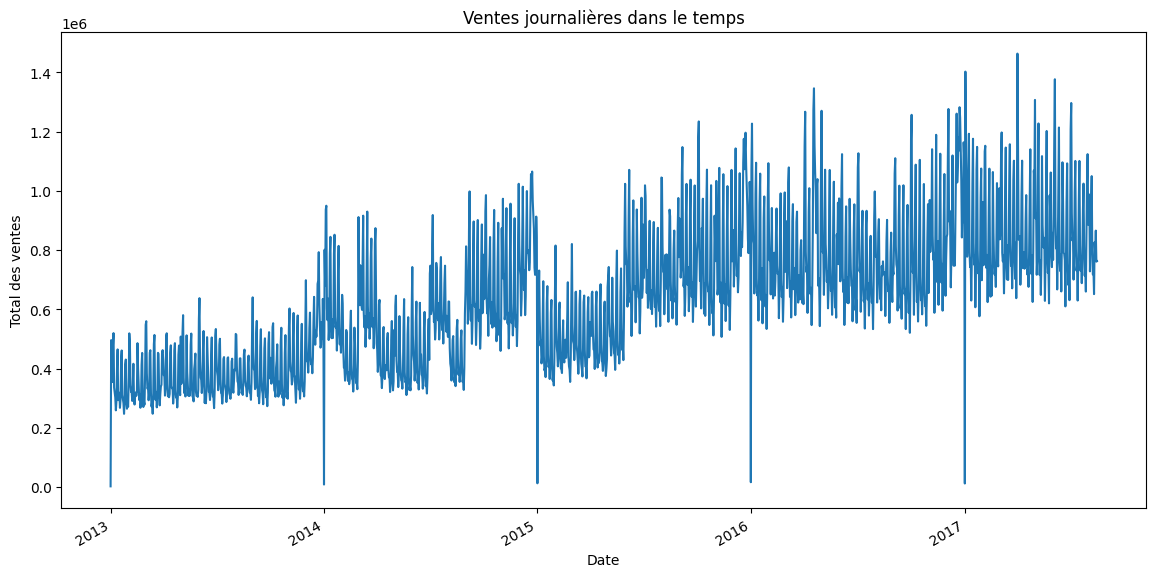

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate sales by date
daily_sales = df.groupby('date')['sales'].sum()

# Plot
plt.figure(figsize=(14, 7))
daily_sales.plot(title='Ventes journalières dans le temps')
plt.xlabel('Date')
plt.ylabel('Total des ventes')
plt.show()

## Store count by city

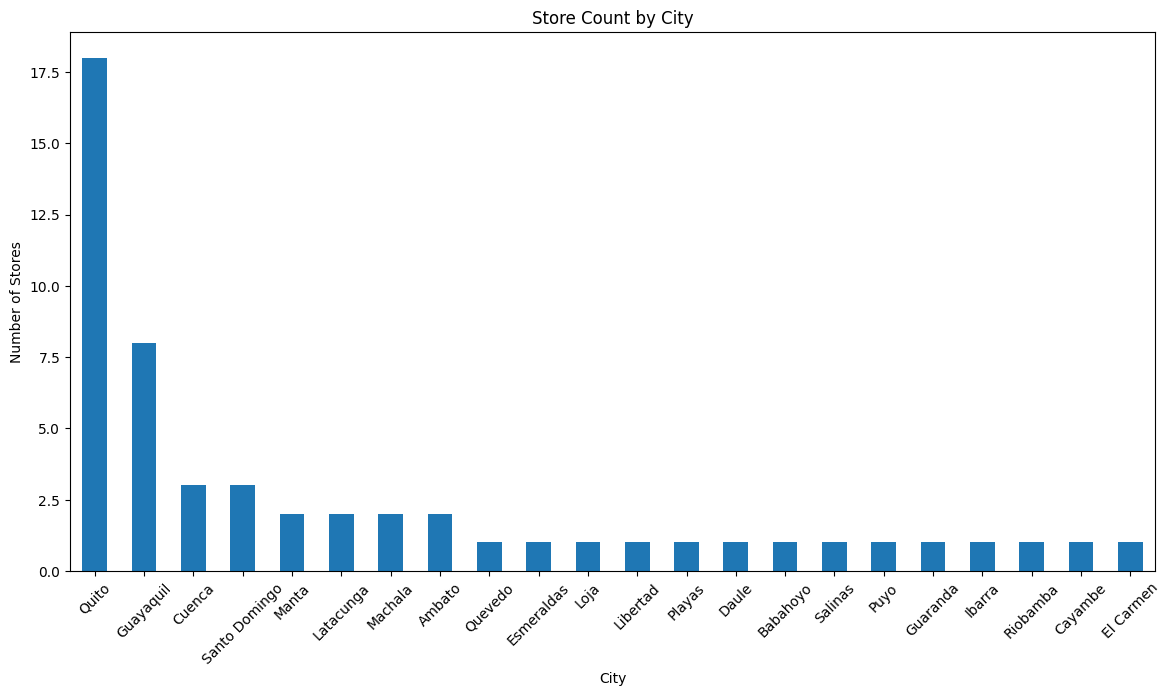

In [11]:
# Count stores by city
stores_by_city = stores_df['city'].value_counts()

# Plot
plt.figure(figsize=(14, 7))
stores_by_city.plot(kind='bar')
plt.title('Store Count by City')
plt.xlabel('City')
plt.ylabel('Number of Stores')
plt.xticks(rotation=45)
plt.show()

## Store distribution by type

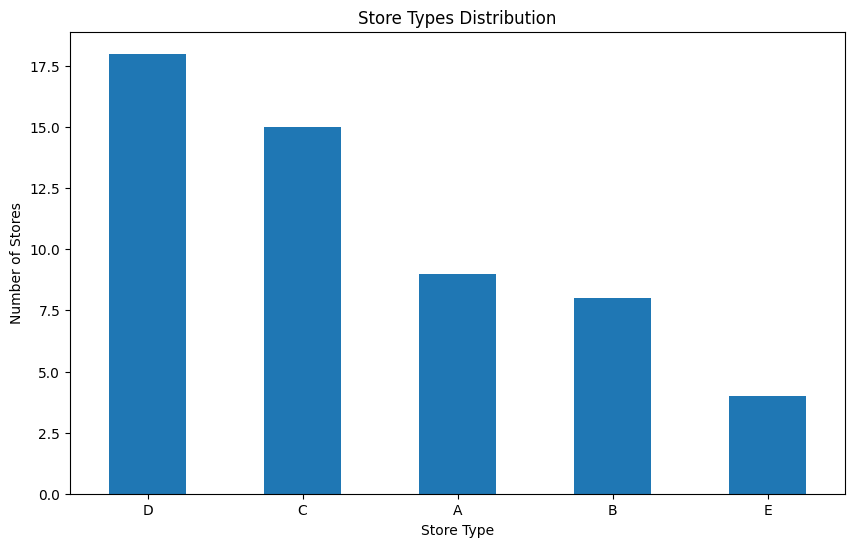

In [12]:
# Count stores by type
stores_by_type = stores_df['type'].value_counts()

# Plot
plt.figure(figsize=(10, 6))
stores_by_type.plot(kind='bar')
plt.title('Store Types Distribution')
plt.xlabel('Store Type')
plt.ylabel('Number of Stores')
plt.xticks(rotation=0)
plt.show()

## Sales distribution by family

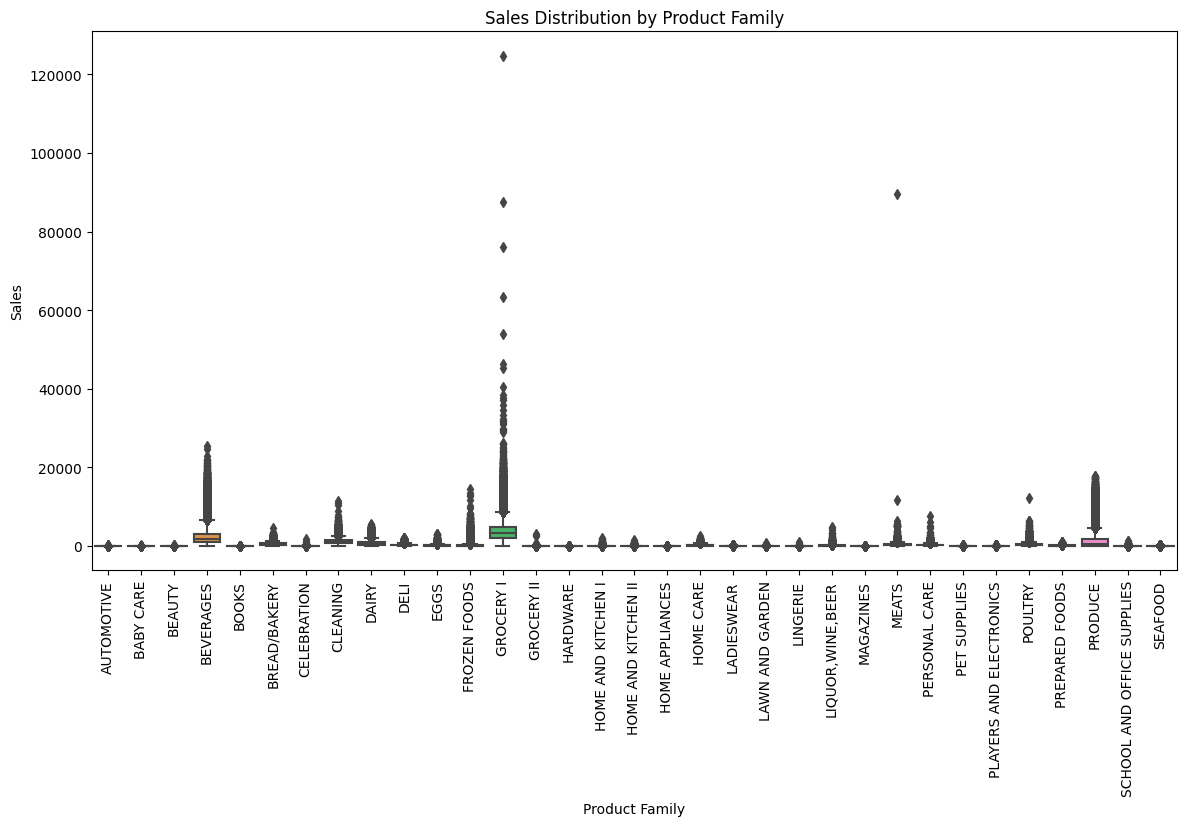

In [13]:
# Plot sales distribution by family
plt.figure(figsize=(14, 7))
sns.boxplot(data=df, x='family', y='sales')
plt.xticks(rotation=90)
plt.title('Sales Distribution by Product Family')
plt.xlabel('Product Family')
plt.ylabel('Sales')
plt.show()

## Ensemble method: Linear Regression x XGBoost (not using temporality/Time Series)

In [14]:
# Merge the DataFrames
df = df.merge(stores_df, on='store_nbr', how='left')
df = df.merge(oil_df, on='date', how='left')
df['dcoilwtico'].fillna(method='ffill', inplace=True)

# Feature engineering for df
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month.astype('category')
df['day_of_week'] = df['date'].dt.dayofweek.astype('category')

# Prepare categorical and numeric features for df
ohe = OneHotEncoder(sparse=True)
ohe_features = ['store_nbr', 'family', 'city', 'state', 'type', 'month', 'day_of_week']
encoded_features = ohe.fit_transform(df[ohe_features])
numeric_features = csr_matrix(df[['year', 'dcoilwtico']].to_numpy())

# Impute missing values in numeric_features
imputer = SimpleImputer(strategy='mean')
numeric_features_imputed = imputer.fit_transform(numeric_features.toarray())
numeric_features = csr_matrix(numeric_features_imputed)

X = hstack([encoded_features, numeric_features])
y = df['sales'].values

/tmp/ipykernel_18/2842589356.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['dcoilwtico'].fillna(method='ffill', inplace=True)
/tmp/ipykernel_18/2842589356.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['dcoilwtico'].fillna(method='ffill', inplace=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 

In [15]:
print('Features used in the models:')
print(ohe_features)
print(['year', 'dcoilwtico'])

Features used in the models:
['store_nbr', 'family', 'city', 'state', 'type', 'month', 'day_of_week']
['year', 'dcoilwtico']


In [16]:
# Train the Linear Regression model
lr = LinearRegression()
lr.fit(X, y)

# Train the XGBoost model
dtrain = xgb.DMatrix(X, label=y)
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'eta': 0.3,
}
bst = xgb.train(params, dtrain, num_boost_round=100)

# Prepare the test dataset
test_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv", parse_dates=['date'])
test_df = test_df.merge(stores_df, on='store_nbr', how='left')
test_df = test_df.merge(oil_df, on='date', how='left')
test_df['dcoilwtico'].fillna(method='ffill', inplace=True)
test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month.astype('category')
test_df['day_of_week'] = test_df['date'].dt.dayofweek.astype('category')

# Prepare features for prediction for the test dataset
encoded_test_features = ohe.transform(test_df[ohe_features])
numeric_test_features = csr_matrix(test_df[['year', 'dcoilwtico']].to_numpy())
X_test = hstack([encoded_test_features, numeric_test_features])

# Predict with Linear Regression
y_pred_lr = lr.predict(X_test)

# Predict with XGBoost
dtest = xgb.DMatrix(X_test)
y_pred_xgb = bst.predict(dtest)

# Average predictions
y_pred_ensemble = (y_pred_lr + y_pred_xgb) / 2

# Assign averaged predictions to test_df
test_df['sales'] = y_pred_ensemble

print("Predictions made successfully with ensemble method.")


Predictions made successfully with ensemble method.


/tmp/ipykernel_18/2580715283.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['dcoilwtico'].fillna(method='ffill', inplace=True)
/tmp/ipykernel_18/2580715283.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_df['dcoilwtico'].fillna(method='ffill', inplace=True)


## Submission

In [17]:
sample_submission = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv")
sample_submission

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0
...,...,...
28507,3029395,0.0
28508,3029396,0.0
28509,3029397,0.0
28510,3029398,0.0


In [18]:
test_df

,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,year,month,day_of_week,sales
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,46.80,2017,8,2,-1.173416
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,46.80,2017,8,2,-4.993172
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,46.80,2017,8,2,-5.480863
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,46.80,2017,8,2,2503.768005
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,46.80,2017,8,2,-10.210845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,Quito,Pichincha,B,6,47.26,2017,8,3,449.520994
28508,3029396,2017-08-31,9,PREPARED FOODS,0,Quito,Pichincha,B,6,47.26,2017,8,3,174.589660
28509,3029397,2017-08-31,9,PRODUCE,1,Quito,Pichincha,B,6,47.26,2017,8,3,1445.574180
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,Quito,Pichincha,B,6,47.26,2017,8,3,90.757878


In [19]:
submission = test_df[['id', 'sales']]
submission.to_csv('submission.csv', index=False)
submission

,id,sales
0,3000888,-1.173416
1,3000889,-4.993172
2,3000890,-5.480863
3,3000891,2503.768005
4,3000892,-10.210845
...,...,...
28507,3029395,449.520994
28508,3029396,174.589660
28509,3029397,1445.574180
28510,3029398,90.757878
